**3.2.4. Bài tập thực hành 2**

Xây dựng mô hình phân cụm đa cấp trên tập dữ liệu mua sắm tại siêu thị. Dữ liệu lấy tại: 
https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

### 1. Chuẩn bị dữ liệu
- Đọc dữ liệu Online Retail, giữ lại bản ghi hợp lệ (CustomerID, Quantity > 0, UnitPrice > 0).
- Tính `TotalPrice = Quantity * UnitPrice` và gom theo khách hàng.
- Tạo các đặc trưng tổng hợp: tổng chi tiêu, số hóa đơn, số dòng, số mặt hàng duy nhất, trung bình giá/ số lượng.
- Chuẩn hóa và giảm chiều PCA (2D) để trực quan.


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

file_path = "Dataset/OnlineRetail.csv"
# Một số bản CSV của bộ Online Retail có ký tự không phải UTF-8, dùng mã hóa Latin-1 và bỏ qua lỗi.
raw_df = pd.read_csv(file_path, encoding="latin1", encoding_errors="ignore")

# Lọc dữ liệu hợp lệ
raw_df = raw_df.dropna(subset=["CustomerID"])
raw_df = raw_df[(raw_df["Quantity"] > 0) & (raw_df["UnitPrice"] > 0)]
raw_df["TotalPrice"] = raw_df["Quantity"] * raw_df["UnitPrice"]

# Gom theo khách hàng
agg_df = (
    raw_df
    .groupby("CustomerID")
    .agg(
        total_spent=("TotalPrice", "sum"),
        invoice_count=("InvoiceNo", "nunique"),
        line_count=("StockCode", "count"),
        distinct_items=("StockCode", "nunique"),
        mean_price=("UnitPrice", "mean"),
        mean_qty=("Quantity", "mean"),
    )
    .reset_index(drop=True)
)

num_cols = agg_df.columns
scaler = StandardScaler()
agg_scaled = scaler.fit_transform(agg_df)

pca = PCA(n_components=2, random_state=42)
agg_2d = pca.fit_transform(agg_scaled)

print("Kích thước sau gom cụm khách hàng:", agg_df.shape)
agg_df.head()


Kích thước sau gom cụm khách hàng: (4338, 6)


,total_spent,invoice_count,line_count,distinct_items,mean_price,mean_qty
0,77183.60,1,1,1,1.040000,74215.000000
1,4310.00,7,182,103,2.644011,13.505495
2,1797.24,4,31,22,5.764839,75.516129
3,1757.55,1,73,73,8.289041,8.643836
4,334.40,1,17,17,3.841176,11.588235


### 2. Phân cụm đa cấp (Agglomerative)
- Dùng 3 cụm, liên kết `average`.
- Vẽ các cụm trên không gian PCA 2D.


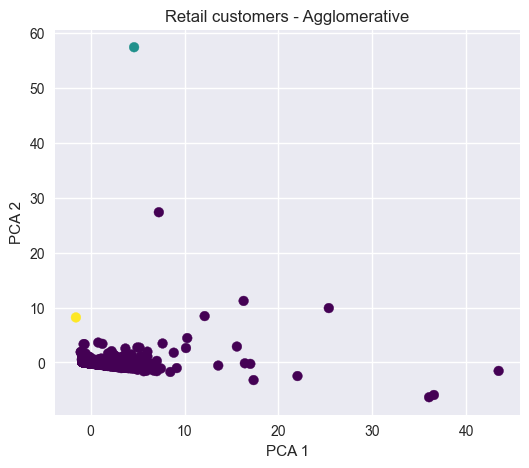

In [8]:
ac = AgglomerativeClustering(n_clusters=3, linkage="average")
ac_labels = ac.fit_predict(agg_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(agg_2d[:, 0], agg_2d[:, 1], c=ac_labels, cmap="viridis")
plt.title("Retail customers - Agglomerative")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### 3. Phân cụm K-Means
- Huấn luyện K-Means với 3 cụm để đối chiếu.
- Vẽ cụm trên PCA 2D.


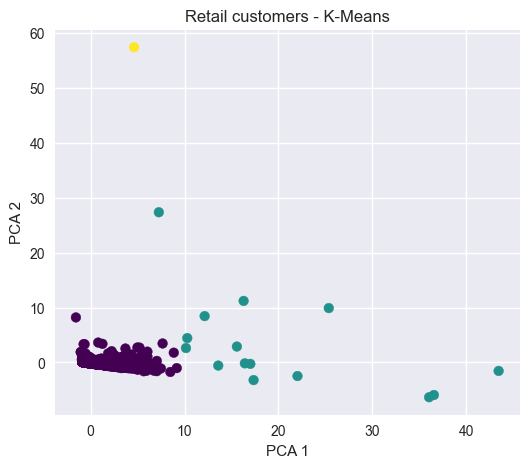

In [9]:
km = KMeans(n_clusters=3, random_state=42, n_init=10)
km_labels = km.fit_predict(agg_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(agg_2d[:, 0], agg_2d[:, 1], c=km_labels, cmap="viridis")
plt.title("Retail customers - K-Means")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### 4. So sánh Silhouette
Tính Silhouette Score cho hai mô hình (cao hơn tốt hơn).


In [10]:
ac_sil = silhouette_score(agg_scaled, ac_labels)
km_sil = silhouette_score(agg_scaled, km_labels)

print("Silhouette Score (cao hơn tốt hơn):")
print(f"Agglomerative: {ac_sil:.3f}")
print(f"K-Means: {km_sil:.3f}")


Silhouette Score (cao hơn tốt hơn):
Agglomerative: 0.976
K-Means: 0.946
